In [35]:
import pandas as pd
import numpy as np
import ast

In [36]:
scene_events_df = pd.read_csv('feat_ablation_sceneXevents_0.csv')

for i, row in scene_events_df.iterrows():
    row['feat_ablation_preds'] = ast.literal_eval(row['feat_ablation_preds'])
    row['scene_events'] = ast.literal_eval(row['scene_events'])
    row['feat_ablation_events'] = ast.literal_eval(row['feat_ablation_events'])

In [37]:
scapper_scenes = scene_events_df['acoustic_scene_label'].unique()
feat_ablation_scene_preds = {scene:[0 for i in range(16)] for scene in scapper_scenes}

for i, row in scene_events_df.iterrows():
    scene = row['acoustic_scene_label']
    #print(row['feat_ablation_preds'])
    for j in range(len(row['feat_ablation_preds'])):
        if scene != row['feat_ablation_preds'][j]:
            feat_ablation_scene_preds[scene][j] += 1


In [38]:
feat_ablation_indices = {scene:[] for scene in scapper_scenes}

for scene in scapper_scenes:
    feat_ablation_indices[scene] = [i for i in range(len(feat_ablation_scene_preds[scene])) if feat_ablation_scene_preds[scene][i] >= 15]

In [70]:
import collections

all_events = set()

for i in scene_events_df['scene_events']:
    for j in i:
        all_events.add(j)

scene_wise_event_counts = collections.defaultdict(dict)
for scene in scapper_scenes:
    scene_wise_event_counts[scene] = collections.defaultdict(dict)
    for i in (list)(all_events):
        scene_wise_event_counts[scene][i] = 0
    for j in scene_events_df[scene_events_df['acoustic_scene_label']==scene]['scene_events']:
        for k in j:
            scene_wise_event_counts[scene][k] += 1

In [72]:
for scene in scapper_scenes:
    scene_wise_event_counts[scene] = sorted(scene_wise_event_counts[scene].items(), key=lambda item: item[1], reverse=True)

In [61]:
events_freq = {event:0 for event in all_events}

for i in scene_events_df['scene_events']:
    for j in i:
        events_freq[j] += 1

In [65]:
events_freq = sorted(events_freq.items(), key=lambda item: item[1], reverse=True)

In [48]:
missed_event_0 = set()

for i, row in scene_events_df[scene_events_df['acoustic_scene_label']=='busystreet'].iterrows():
    tru_ = row['scene_events']
    pred_ = row['feat_ablation_events'][1]
    for j in range(len(tru_)):
        if tru_[j] not in pred_:
            missed_event_0.add(tru_[j])

In [76]:
import collections

d = collections.defaultdict(dict)

for scene in scapper_scenes:
    d[scene] = {i:0 for i in (list)(all_events)}


SyntaxError: invalid syntax (4217839361.py, line 6)

In [1]:
import pandas as pd
import numpy as np
import librosa
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels
import torch

import sys
sys.path.append("../ASC_AED_JoinTask/Datasets/")

import datasets

In [3]:
def string_to_list(events_string):
    if events_string == '[]':
        return []
    else:
        return_list = events_string[1:-1].split("', '")
        return_list[0] = return_list[0].split("'")[1]
        return_list[-1] = return_list[-1].split("'")[0]
        return return_list

In [4]:
scapper_df = pd.read_csv('../ASC_AED_JoinTask/predictions/scapper_preds/scrapper_test_panns_eventsInference.csv')
pred_events_col = 'scrapper_panns_inference_events_list'

In [5]:
scapper_df[pred_events_col].iloc[0]

"['Speech', 'Telephone bell ringing', 'Telephone', 'Music', 'Vehicle', 'Alarm clock', 'Inside, small room', 'Laughter', 'Giggle']"

In [6]:
all_events = set()

for index, row in enumerate(scapper_df[pred_events_col]):
    #print(row)
    event_list = string_to_list(row)
    for event in event_list:
        all_events.add(event)

In [7]:
import math

new_events_df = pd.DataFrame(index=(list)(all_events), columns=scapper_df['acoustic_scene_label'].unique())

for index, row in scapper_df.iterrows():
    #print(row['acoustic_scene_label'], row[pred_events_col])
    for i in string_to_list(row[pred_events_col]):
        if math.isnan(new_events_df[row['acoustic_scene_label']][i]):
            new_events_df[row['acoustic_scene_label']][i] = 0
        new_events_df[row['acoustic_scene_label']][i] += 1

new_events_df = new_events_df.fillna(0)

In [8]:
import seaborn as sns

scene_events_dict = {}

for scene in new_events_df.columns:
    scene_events_dict[scene] = new_events_df[scene][new_events_df[scene] > 0].sort_values(ascending=False)

/work/dpandya/miniconda3/envs/noiseremoval/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


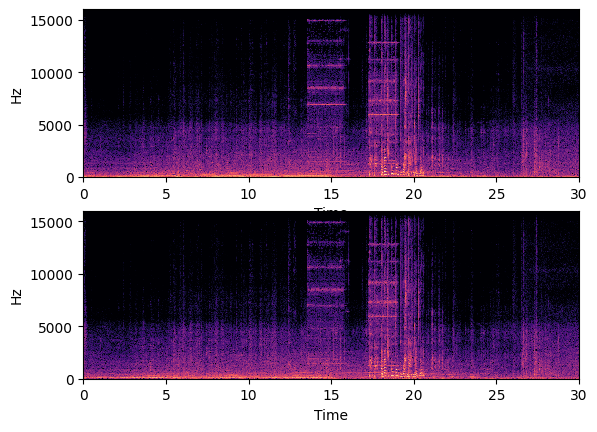

In [9]:
import panns_inference
import sys
import librosa
import os
sys.path.append("../ASC_AED_JoinTask/Datasets/")
import datasets
import audio_utils as au
from IPython.display import display, Audio
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
#model_path00 = '../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth'

sample = os.path.join(datasets.SCAPPER_AUD_DIR + 'test/', scapper_df['audio_fileNames'].iloc[0]) 
audio = au.load_audio_from_file(sample, sample_rate=au.SAMPLE_RATE)
#audio, sr = torchaudio.load(sample)
stf = librosa.stft(audio, n_fft=au.N_FFT, hop_length=au.HOP_LEN)
new = librosa.power_to_db(np.abs(stf)**2, ref=np.max)
log_mel = au.get_log_melSpectrogram(audio, n_fft=au.N_FFT, hop_len=au.HOP_LEN, n_mels=641)

plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stf), ref=np.max), y_axis='linear', x_axis='time', sr=au.SAMPLE_RATE, hop_length=au.HOP_LEN, n_fft=au.N_FFT)
plt.subplot(2, 1, 2)
librosa.display.specshow(new, sr=au.SAMPLE_RATE, hop_length=au.HOP_LEN, x_axis='time', y_axis='linear', n_fft=au.N_FFT)
#display(Audio(audio, rate=au.SAMPLE_RATE))


In [121]:
(stf == log_mel.squeeze().numpy()).sum()

0

In [106]:
spec.shape

(257, 5168)